In [1]:
#define the object name which is the folder name above
OBJ='toi05956.01'

In [2]:
#check the date inside the object folder 
!ls /data/MuSCAT2/photometry_output/$OBJ

230417	230418	230430	230502


In [3]:
#define date available above
DATE='230418'

## check photometry output

Copy the path above and paste below to display png

![image](./photometry/230418/toi05956.01_230418_MuSCAT2_z_s_field.png)

## compare FOV with database 

Plot FOV from database to show . If this shows an error, it's OK. It will not affect TFOP analysis. 

In [1]:
import sys

sys.path.insert(0, "/raid_ut3/home/muscat/miniconda3/envs/m2pipeline/lib/python3.6/site-packages")

In [2]:
from muscat2ta.tfopanalysis import TFOPAnalysis

OBJ='toi05956.01'
DATE='230418'

In [3]:
import numpy as np

TID=0            #target id
CIDS=[1,2,3,4,5] #comparison id(s); can be guesses for now

ta = TFOPAnalysis(target=OBJ, 
                  date=DATE, 
                  tid=TID, 
                  cids=CIDS, 
                  dataroot='./photometry', 
                  mjd_start=-np.inf,
                  mjd_end=np.inf,
#                   excluded_mjd_ranges=[(),()],
#                   aperture_lims=(0, 7),    # 
                  passbands=('r', 'i', 'z_s'),
                  use_opencl=True,          #True will run analysis in parallel
#                   with_contamination=False, #with_contamination=True estimates contamination
                  radius_ratio='chromatic' #means different Rp/Rs parameters for each band; 
#                   radius_ratio='achromatic', #means single Rp/Rs for all bands
#                   excluded_stars=(5,)      # comma is important if only 1 starid is used
                 )
ta.lpf.ps

In [4]:
#print the indices that correspond to which aperture used in photometry
photometry_datasets = ta.phs[0]._ds #0 is for g-band
apertures_in_pixels = photometry_datasets.aperture.data
print('index\taperture [pix]')
for index,aperture in enumerate(apertures_in_pixels):
    print(f'{index}\t{aperture}')

index	aperture [pix]
0	4
1	7
2	10
3	13
4	16
5	19
6	22
7	25


In [6]:
from uncertainties import ufloat

zero_epoch = ufloat(2459893.78503, 0.00038)
period = ufloat(0.9291220, 0.0000093)
tdur = ufloat(0.04347, 0.00268)

(ta.lpf.times[0].mean()-zero_epoch.n)/period.n

172.03471610316288

In [7]:
ta.set_prior('tc', 'UP', ta.lpf.times[0][0], ta.lpf.times[0][-1])
ta.set_prior('p', 'NP', period.n, period.s)
ta.lpf.ps[3].bounds = (0, 1.5)
ta.set_prior('b', 'UP', 0, 1.3)

# Plot raw light curves

These plots show the raw absolute light curves for the target and the brightest stars in the field. The plots will not be saved, but help when choosing the reference stars. These figures will not be saved.

# Clean raw light curves 

##  trimming/cutting

If the light curve contains spans of bad data, they can be trimmed away usin ta.cut(). The method will remove the data between tstart and tend. If you want to cut all the data from beginning till START_TIME, you can call the method as
```
ta.lpf.cut(tend=START_TIME, apply=False)
```
if you want to cut all the data after END_TIME, you can call the method as
```
ta.lpf.cut(tstart=END_TIME, apply=False)
```
and if you want to remove the data between times T1 and T2, you can call the method as
```
ta.lpf.cut(tstart=T1, tend=t2, apply=False)
```
Note: You need to set apply=True to actually apply the outlier removal. By default the command only plots what would be removed if apply would be True.

## Outlier removal

The pipeline comes with several ways to remove outliers, of which `ta.lpf.apply_normalized_limits(aid, lower, upper, apply, plot, npoly, iterations)` is the most user friendly. The method removes points with relative normalised flux smaller than lower and larger than upper.

Note: You need to set `apply=True` to actually apply the outlier removal. By default the command only plots what would be removed if apply would be True.

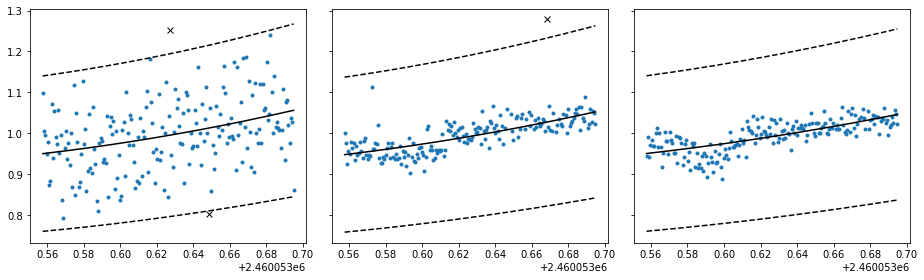

In [13]:
ta.apply_normalized_limits(4, lower=0.8, upper=1.2, apply=True, plot=True, npoly=2, iterations=5)

## Downsampling

The light curves can be downsampled (binned) to 30-60 second exposures in most cases without compromising the quality of the analysis. This can speed up the analysis significantly, and is especially recommended with bright TESS targets.

# Plot possible blends

Plot the raw fluxes from all the stars that are within 2.5 arcmin from the target. The plot is saved to the final output directory.

These plots are important for TFOP and will be saved in the result directory. The plots show the raw light curves for the target star and all the stars around it within a given radius (unbinned and binned). The plots also show the expected times for the transit start, centre, and end (with their uncertainties), and the expected transit signal with depth corresponding to the depth that would be observed if the transit would be on the blending star (in reality we'd expect to see even deeper signal, because these plots assume blending only between the target and the possible blend, while in reality the blend is blended with multiple sources). The plots show the flux ratio between the target and the possible contaminant on the top-right corner.

ta.plot_possible_blends requires two arguments

* cid: comparison star index. Should be a bright (non-saturated) star outside a 2 arcmin radius of the target star.
* aid: aperture index. The aperture should be large enough to capture the flux of the brightest star within 2 arcmin from the target.

# Plot covariates

Plot the covariates for all the passbands and save the figure in the final output directory.

# Export the raw data

Export the photometry in .csv files that are saved in the final output directory.

## Transit modelling

### Global optimisation

Transit modelling starts with a global optimisation run using `TFOPAnalysis.optimize`. This step optimises the set of comparison stars, target and comparison star apertues, a baseline model using the covariates and (optional) time variability modelled as Legendre polynomials, and (optional) transit model.

The global optimisation can be done semi-interactively. First run the optimisation (run the cell below) with a small number of iterations (200-500) and plot the fit (run the second cell below). Next, run the optimisation again (run the cell below), and the optimiser will continue from where it left, and again check the optimisation by plotting the fit. If everything looks fine (the optimiser seems to be converging to a sensible solution), do a longer optimisation run (1000-2000 iterations), plot the fit, and continue to sampling. If the optimisation stops before it reaches the number of iterations, it has converged to a point, and you can continue to sampling

Optimizing the model:   0%|          | 0/500 [00:00<?, ?it/s]

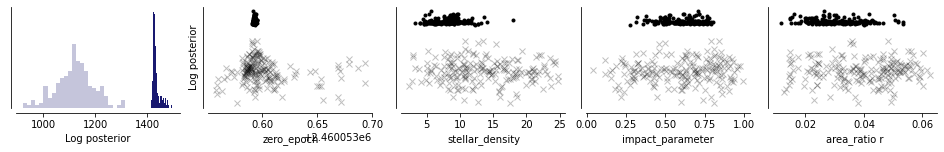

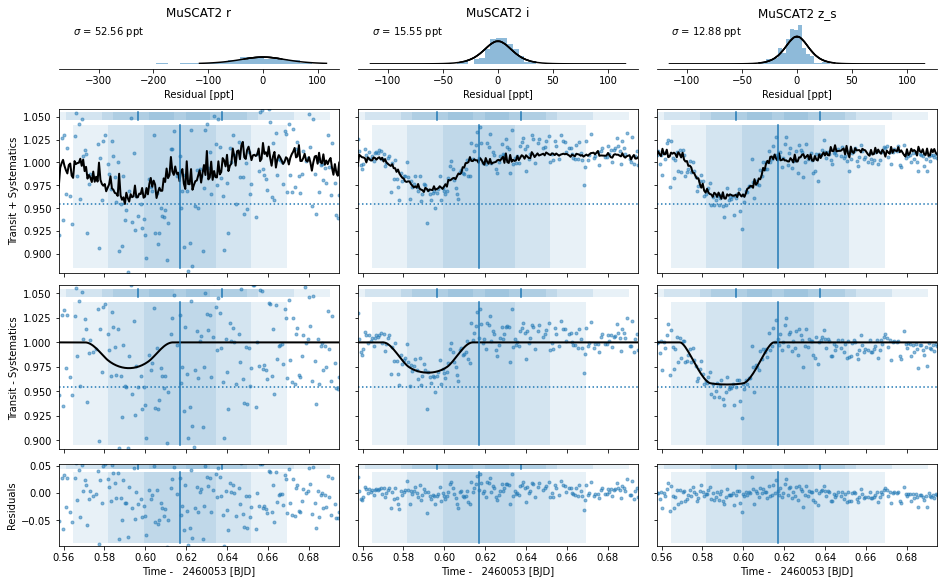

In [9]:
#optimize the parameter set using differential evolution
ta.optimize(500)

fig, axs = ta.plot_fit('de');

Optimizing the model:   0%|          | 0/500 [00:00<?, ?it/s]

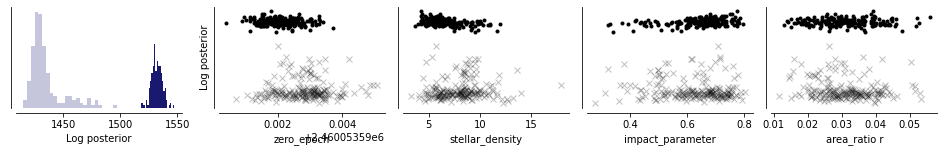

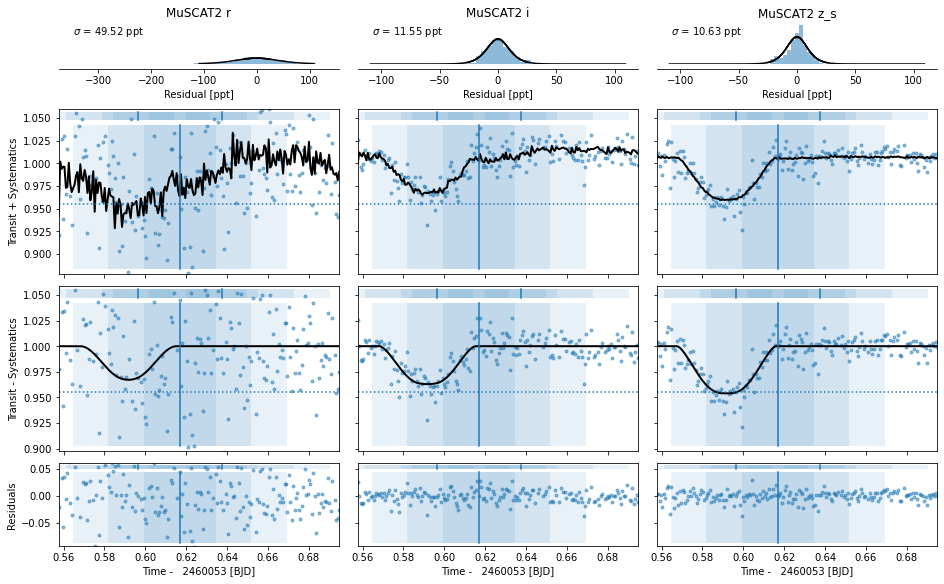

In [10]:
#optimize the parameter set using differential evolution
ta.optimize(500)

fig, axs = ta.plot_fit('de');

### MCMC sampling

The MCMC sampling of the posterior is done using `TFOPAnalysis.sample`. First, the set of comparison stars and target and comparison apertures should be frozen using `TFOPAnalysis.freeze_photometry`. This reduces the number of free parameters, and significantly improves the MCMC sampling efficiency. We'll also follow the freezing with a small optimisation step.

In [11]:
#run this if you're satisfied with the results of optimization above
ta.freeze_photometry()

The sampling can be done the same way as optimisation. Run the sampler for some (500-1000) iterations and plot the fit. Also check the chain population using `TFOPAnalysis.plot_mcmc_chains` to see how well the sampler is behaving. Do a longer final MCMC run after everything looks ok, and continue.

Optimizing the model:   0%|          | 0/200 [00:00<?, ?it/s]

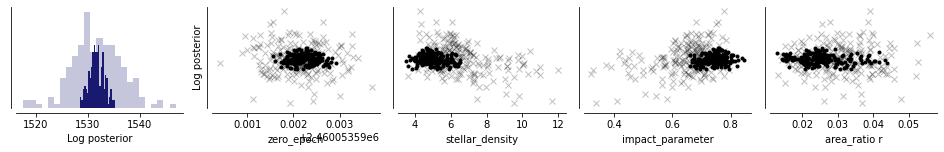

In [12]:
#check if model can be further improved after fixing cids and aperture sizes
ta.optimize(200)

In [39]:
ta.lpf.plot_light_curves??

In [35]:
ta.plot_fit??

Sampling the model:   0%|          | 0/2 [00:00<?, ?it/s]

Run 1/2:   0%|          | 0/3000 [00:00<?, ?it/s]

Run 2/2:   0%|          | 0/3000 [00:00<?, ?it/s]

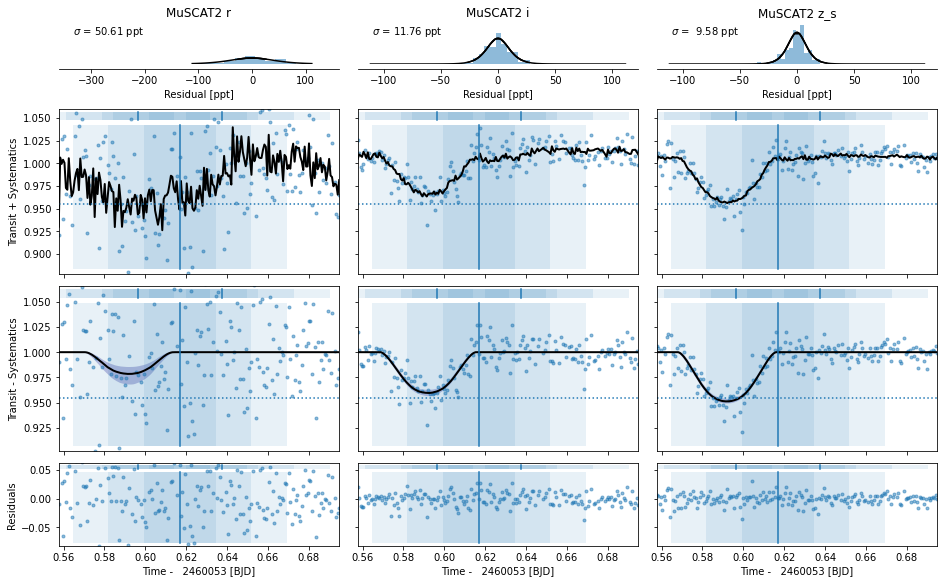

In [13]:
#run mcmc sampling with emcee (ensemble sampler)
ta.sample(niter=3000, repeats=2)

fig, axs = ta.plot_fit('mc');

In [14]:
#check the total number of emcee steps taken by each parameter
fc = ta.lpf.sampler.flatchain
fc.shape

(120000, 31)

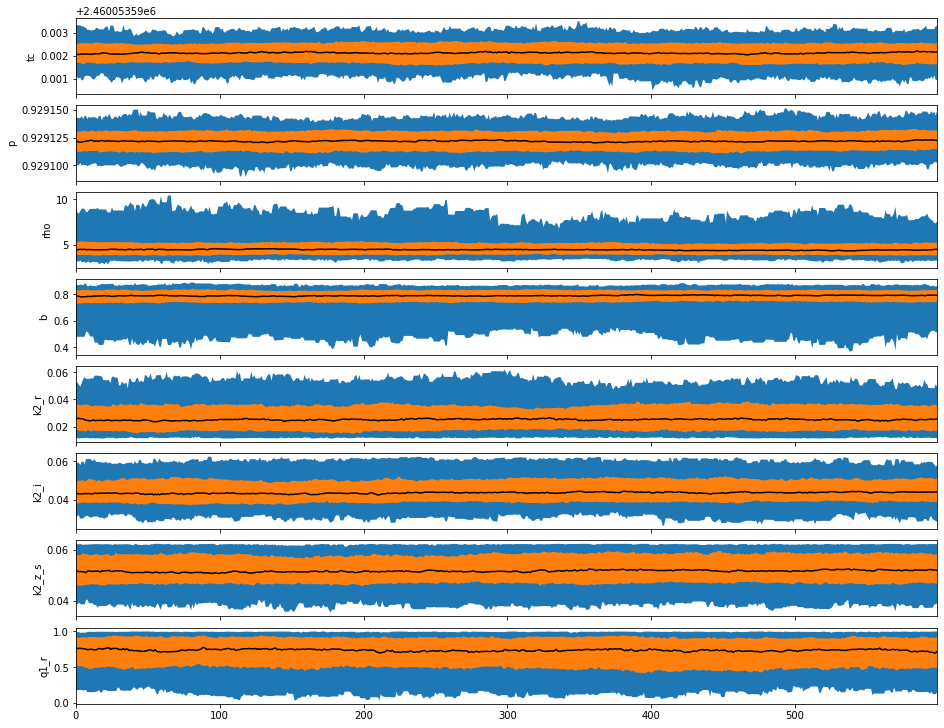

In [15]:
#plot mcmc chains for parameter ids 0 to 8; x-axis is number of mcmc steps
ta.lpf.plot_chains(pids=range(8))

### posterior joint plot

In [16]:
names=ta.lpf.ps.names
names[:5] #first 4 parameters

['tc', 'p', 'rho', 'b', 'k2_r']

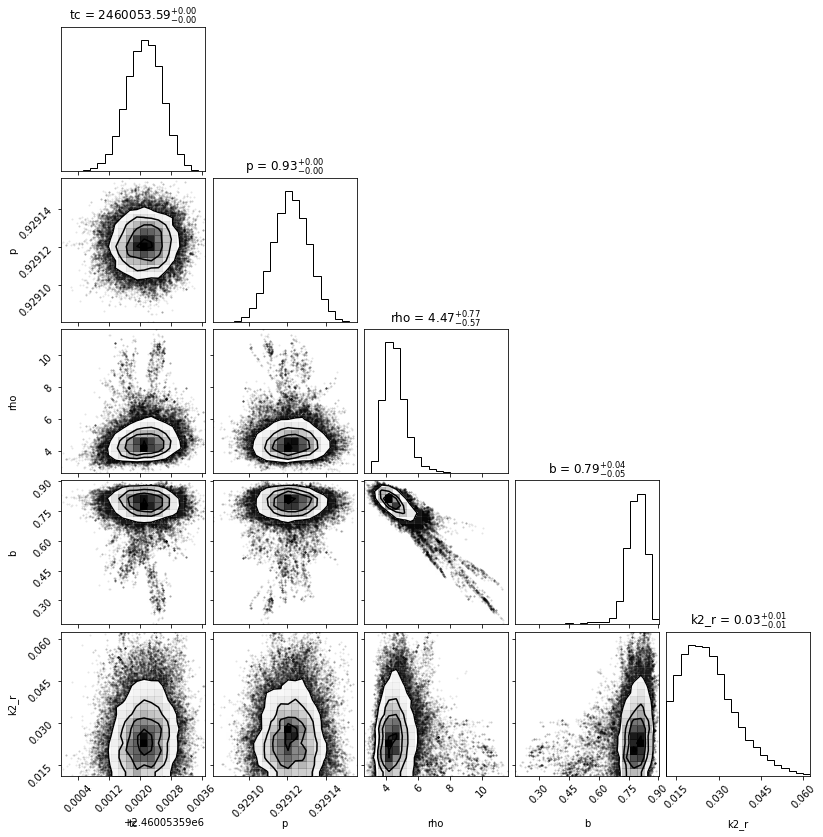

In [27]:
from corner import corner

fig = corner(fc[:,:5],
             labels=names[:5],
             show_titles=True,
             title_fmt='.2f'
            );

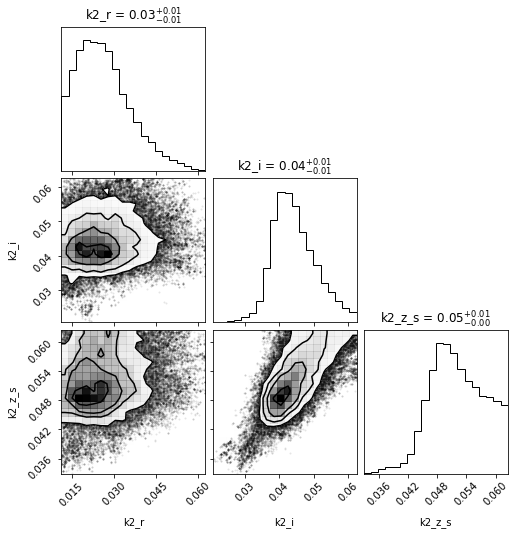

In [28]:
import pandas as pd

df = pd.DataFrame(fc, columns=names)
cols = df.columns[df.columns.str.contains('k2')]
fig = corner(df[cols],
             show_titles=True,
             title_fmt='.2f'
            )

# Plot the final Report

Text(0.5, 0.98, 'TOI-5956.01 | 230418')

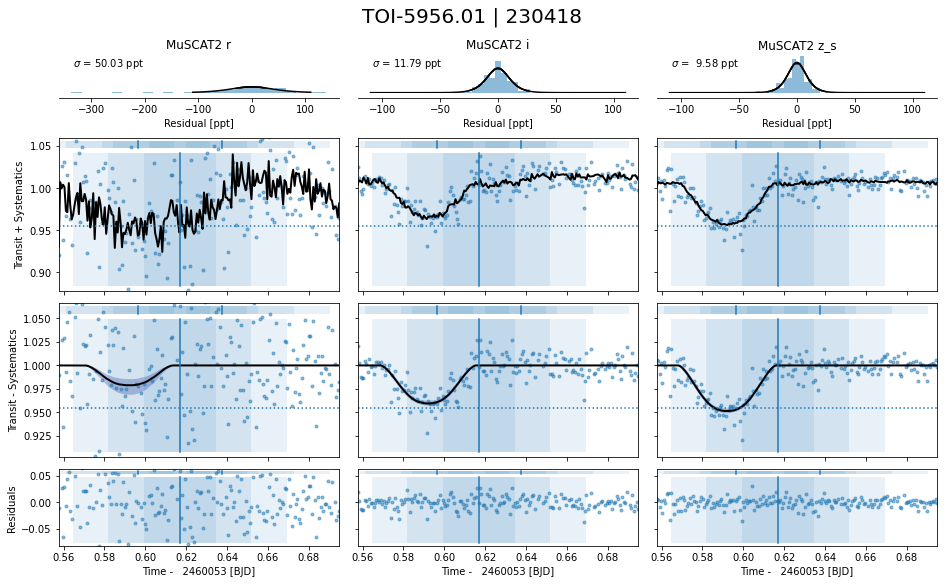

In [33]:
fig, axs = ta.plot_fit('mc');
fig.suptitle(f"TOI-5956.01 | {DATE}", fontsize=20)

# Save the MCMC sampling and the reduced light curve

In [30]:
#save files for tfop report
ta.save()

In [31]:
#save auxiliary data into fits file
ta.save_fits()

In [32]:
#put saved files into appropriate folder location
ta.finalize()

# Saved Files for TFOP Upload


See [pipeline manual](https://docs.google.com/document/d/1vH7nxZWEB2RPH-yBtyheVWaG0sBeKn977M-J3zS7Ktg/edit#heading=h.m41504xcw9ax) for the list of files to be uploaded and their interpretation.